In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import seaborn as sns
from colossus.cosmology import cosmology

import matplotlib as mpl
# set fontsize for plots
font = {'family' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)
from astropy.cosmology import Planck18 as Planck18, z_at_value

In [5]:
def halo_mass_function(M, bins=50, volume=1000):
    import numpy as np

    # Define logarithmic mass bins
    logM = np.log10(M)
    bin_edges = np.linspace(min(logM), max(logM), num=bins).flatten()  # equally spaced bins in log-space
    print(bin_edges)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    dlogM = bin_edges[1] - bin_edges[0]
    
    # # Initialize an array to store the halo counts in each bin
    # halo_counts = np.zeros(len(bin_centers))

    # # Count the halos in each mass bin
    # for i in range(len(bin_centers)):
    #     mass_min = 10 ** bin_edges[i]
    #     mass_max = 10 ** bin_edges[i + 1]
    #     halo_counts[i] = np.count_nonzero((M >= mass_min) & (M < mass_max))

    # histogram the log masses
    halo_counts, _ = np.histogram(logM, bins=bin_edges)

    # Calculate the halo mass function dn/dlogM
    dn_dlogM = (1 / (dlogM * volume)) * halo_counts

    # Print the results
    for i in range(len(bin_centers)):
        print(f"Bin center: {bin_centers[i]:.2f}, dn/dlogM: {dn_dlogM[i]:.6e} Mpc^-3 dex^-1")

    return(bin_centers, dn_dlogM)
        


# def plot_halo_mass_function(masses, bins=50, volume=1e9):
    """
    Plots the halo mass function (dlogN/dlogM) given an array of halo masses.
    
    Parameters
    ----------
    masses : array_like
        An array of halo masses.
    bins : int, optional
        The number of bins to use for the histogram. Default is 50.
    volume : float, optional
        The volume of the simulation box in Mpc^3. Default is 1e9 Mpc^3.
    """
    
    # Compute the logarithmic bin edges
    log_masses = np.log10(masses)
    log_min = np.floor(np.min(log_masses))
    log_max = np.ceil(np.max(log_masses))
    log_bins = np.logspace(log_min, log_max, num=bins+1)
    # Compute the histogram
    counts, _ = np.histogram(masses, bins=log_bins)
    
    # Compute the halo mass function
    bin_centers = 0.5*(log_bins[:-1] + log_bins[1:])
    print("bin centers", bin_centers)
    bin_widths = log_bins[1:] - log_bins[:-1]
    dndm = counts / (bin_widths * volume)
    dndlogm = dndm / bin_centers
    
    return bin_centers, dndlogm
    

Planck18 Omega h^2:  0.143063263488
OM22_fix_physdens
Average density for Omega M = OM22_fix_physdens 594.9085013333333
0.5000000014985296 redshift
[ 8.608671   8.739622   8.870573   9.001523   9.132474   9.263425
  9.394376   9.525326   9.656277   9.787228   9.918179  10.0491295
 10.180079  10.31103   10.441981  10.572932  10.703882  10.834833
 10.965784  11.096735  11.227686  11.358637  11.489587  11.620538
 11.751489  11.882439  12.01339   12.1443405 12.275291  12.406242
 12.537193  12.668143  12.799094  12.930045  13.060995  13.191946
 13.322897  13.453848  13.584799  13.71575   13.8467    13.977651
 14.108602  14.239552  14.370502  14.501453  14.632404  14.763355
 14.894306  15.025256 ]
Bin center: 8.67, dn/dlogM: 3.977317e-08 Mpc^-3 dex^-1
Bin center: 8.81, dn/dlogM: 2.651545e-08 Mpc^-3 dex^-1
Bin center: 8.94, dn/dlogM: 2.651545e-08 Mpc^-3 dex^-1
Bin center: 9.07, dn/dlogM: 2.651545e-08 Mpc^-3 dex^-1
Bin center: 9.20, dn/dlogM: 7.954634e-08 Mpc^-3 dex^-1
Bin center: 9.33, dn/dlo

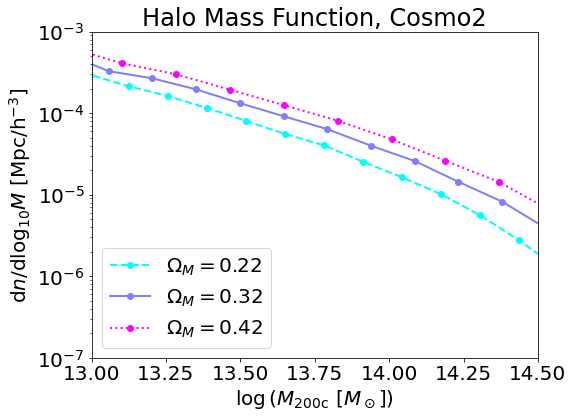

In [8]:
fig, ax = plt.subplots(figsize=[8,6])

cm = plt.cm.get_cmap('cool')
fix_density = True
i = 0
P18 = cosmology.setCosmology('planck18-only') # consistent with the Peak Patch setup
P18_omegam = P18.Om0
omegam_varied = np.linspace(P18_omegam-0.1,P18_omegam+0.1,5)
P18_h = P18.h
addon = ''
if fix_density:
    addon = '_fix_physdens'
    omh2 = P18_omegam*P18_h**2
    print("Planck18 Omega h^2: ", omh2)
    h_varied = np.sqrt(omh2/omegam_varied)
    H0_varied = 100*h_varied
else:
    h_varied = [P18.h,P18.h,P18.h,P18.h,P18.h]
linestyles = ['dashed', 'solid', 'dotted']
for i in range(0,len(omegam_varied),2):
    OMstring = "OM{:d}{:s}".format(int(round(omegam_varied[i]*100)), addon)
    print(OMstring)
    f = h5.File("/mnt/raid-cita/mlokken/pkpatch/2400Mpc_n442_nb28_nt4_{:s}_merge.hdf5".format(OMstring))
    new_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[i], H0=h_varied[i]*100.)
    new_cosmo_astropy = new_cosmo.toAstropy()
    bins = np.linspace(12,14.5,20)
    # print the average density of the entire box
    avg_density = np.mean(f['m200m'][:])/(2400**3)
    print("Average density for Omega M = {:s}".format(OMstring), avg_density)
    z = f['z'][:]
    pos = f['pos'][:]
    # convert x,y,z, pos into comoving distance
    chi = np.sqrt(pos[0,:]**2 + pos[1,:]**2 + pos[2,:]**2)
    cbin_cent = new_cosmo_astropy.comoving_distance(0.5)
    
    # cbin_cent = Planck18.comoving_distance(0.5)
    
    print(z_at_value(new_cosmo_astropy.comoving_distance, cbin_cent))
    chibin = (cbin_cent.value-50<chi) & (chi<cbin_cent.value+50)
    bin_centers, dndlogm = halo_mass_function(f['m200m'][:][chibin], bins=50, volume=2400**2*100)
    
    # plt.hist(np.log10(f['m200m'][:][chibin]), bins=bins+i/50., color=cm(i/3), histtype='step', linewidth=2, label=r"$\Omega_M=0.{:s}$".format(OMstring[2:4]))
    # Plot the results
    ax.semilogy(bin_centers, dndlogm, marker='o', label=r"$\Omega_M=0.{:s}$".format(OMstring[2:4]), color=cm(i/4), linestyle=linestyles[i//2], linewidth=2)
    
    f.close()
    i+=1



# Plot the halo mass function

    
plt.title('Halo Mass Function')

ax.set_xlabel(r'$\log{(M_\mathrm{200c} \ [M_\odot])}$')
ax.set_ylabel(r'$\mathrm{d}n/\mathrm{d}\log_{10} M \ [\mathrm{Mpc/h}^{-3}]$')
if fix_density:
    cosmostr = "Cosmo2"
else:
    cosmostr = "Cosmo1"
ax.set_title(f'Halo Mass Function, {cosmostr}')
ax.set_xlim([13, 14.5])
ax.set_ylim([10**-7, 10**-3])

plt.legend()
plt.savefig(f"../../plots/paper2/hmf_{cosmostr}.pdf", bbox_inches='tight', dpi=300)
plt.show()
# plt.ylim([0,2500])
# plt.ylabel("Number of Halos")
# plt.xlabel(r"$\log(M/M_\odot$)")
    

In [21]:
# pkfile       = open("/mnt/raid-cita/mlokken/pkpatch/tiling_bug_test_ntile3_merge.pksc.13579", "rb") # Nate's runpkfile       = open("/mnt/raid-cita/mlokken/pkpatch/2700Mpc_n460_nb21_nt3_OM32_merge.pksc.13579", "rb")
# pkfile       = open("/mnt/raid-cita/mlokken/pkpatch/2700Mpc_n460_nb21_nt3_OM22_merge.pksc.13579", "rb") # my run
pkfile = open("/mnt/raid-cita/mlokken/pkpatch/2400Mpc_n442_nb28_nt4_OM32_fixomh2_merge.pksc.13579")


Nhalo        = np.fromfile(pkfile, dtype=np.int32, count=3)[0]
print("Number of halos:%d\n" %Nhalo)

catalog = np.fromfile(pkfile,count=Nhalo*11,dtype=np.float32)
catalog = np.reshape(catalog,(Nhalo,11))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

Number of halos:9906201



In [ ]:
rho = 2.775e11*0.317*.676**2 # Msun/Mpc^3
M200m    = 4*np.pi/3.*rho*R**3  
bins = np.linspace(5*10**13, 2.5*10**14, 50)


In [ ]:
(2700-21*2)/(3*460)

In [ ]:
bins = np.linspace(9*10**12,2*10**13,100)


In [ ]:
plt.hist(M200m, bins=bins)
plt.xlabel("Mass")

In [ ]:
plt.hist(R, bins=np.linspace(2, 8, 100))
plt.xlabel("Radius [Mpc]")

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(x,y, s=.01, alpha=.1)


In [ ]:
# mlim = (M200m > 1*10**13) & (M200m<1.5*10**13)
mlim = M200m<1*10**13
plt.figure(figsize=[10,10])
plt.scatter(x[mlim],y[mlim], s=.05, alpha=.01)


In [ ]:
(2e10/(rho*4/3*np.pi))**(1/3)

In [ ]:
slicelist = []
for xlim in np.arange(-2700, 0, 100):
    slice = (x>xlim)&(x<(xlim+50))
    slicelist.append([y[slice], z[slice]]) 
    plt.scatter(y[slice], z[slice], alpha=.5, s=2)
    plt.show()
    plt.clf()

In [ ]:
slicelist = []
for ylim in np.arange(-2700, 0, 100):
    slice = (y>ylim)&(y<(ylim+50))
    slicelist.append([x[slice], z[slice]]) 
    plt.scatter(x[slice], z[slice], alpha=.5, s=2)
    plt.show()
    plt.clf()

In [ ]:
for slice in slicelist:
    plt.scatter(slice[0], slice[1], s=1, alpha=.1, color='blue')